In [83]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

## Goals of this Notebook

- Do final feature prep: 1) build a RF to get top ranked features, 2) identify all features that should be left out (i.e., are non-generalizable), 3) retrain RF to get a rank-ordered list of all features
- Build new models with increasing numbers of features: 1) do full hyper-param search using CV, 2) report CV error
- Build a classifier

In [197]:
'''
This is pre-groomed data from the Prep_Model_Data notebook
'''

data_dir_june = '/Users/briandalessandro/Documents/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
model_df = pd.read_csv(data_dir_june + 'processed/training_all_in.csv')


In [198]:
#These are features we'll exclude, as they're not useful for generalization
non_model_features = ['start','submission_time','end','device_id','country','developer_code', 
                      'village_code', 'joint_code', 'gps_coordinates',
                       'gps_coordinates_latitude', 'gps_coordinates_longitude',
                       'gps_coordinates_altitude', 'gps_coordinates_precision',
                       'meter_number','survey_version','meta_instanceid', 'id', 'uuid', 'index', 
                       'parent_index', 'customer_id','start_date','end_date','tariff_min','tariff_max']

In [199]:
#Double check that all features are numbers

a=list(set(model_df.columns.values) - set(non_model_features))
ll = []
for v in a:
    if type(model_df[v].loc[0]) == str:
        print(v)

In [200]:
#Clean outliers in the target column
Y = 'avg_consumption'
max_thresh=1

model_df.loc[model_df[Y]>max_thresh, Y] = max_thresh
model_df[Y].describe()

count    1859.000000
mean        0.097208
std         0.157251
min         0.000000
25%         0.016740
50%         0.037028
75%         0.105633
max         1.000000
Name: avg_consumption, dtype: float64

## Check for Feature Importance at Top Level

In [205]:
#Goal here is to just get feature rankings by IG, not to get a good fit

model_train = model_df.drop(non_model_features, axis=1)

#Fit model
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5)
rf.fit(model_train.drop(Y,axis=1), model_train[Y])

#Add to DF
feat_imp = pd.DataFrame({'x':model_train.drop(Y,axis=1).columns.values,'imp':rf.feature_importances_})
feat_imp = feat_imp.sort_values(by=['imp'], ascending=False).reset_index(drop=True)

#Get sign of relationship - probably faster way to do this
xs = feat_imp.x.values

betas = []
signs = []

for x in xs:
    beta = LinearRegression().fit(model_df[x].values.reshape(-1,1), model_df[Y]).coef_[0]
    betas.append(beta)
    if beta < 0:
        signs.append('neg')
    else:
        signs.append('pos')

feat_imp['lin_coef'] = betas
feat_imp['direction'] = signs


Now let's understand top features

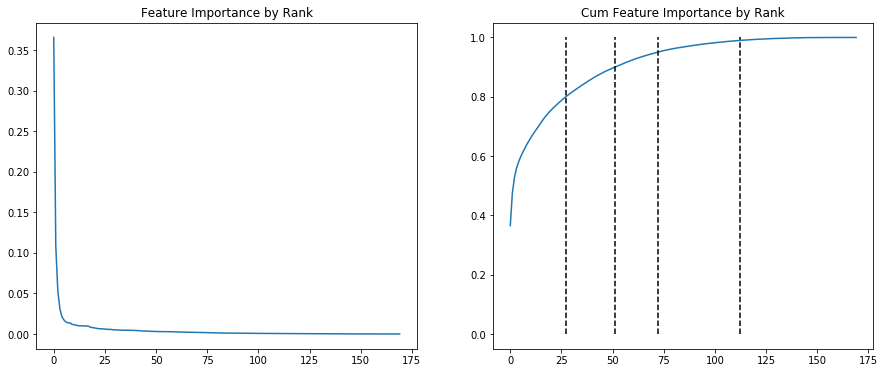

In [206]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
plt.plot(feat_imp.imp)
plt.title('Feature Importance by Rank')

n = feat_imp.shape[0]
ax1 = fig.add_subplot(1,2,2)
plt.plot(np.cumsum(feat_imp.imp))
plt.title('Cum Feature Importance by Rank')

#Get positions corresponding to 80%, 90%, 95% and 99% feature importance
cs = np.cumsum(feat_imp.imp.values)
f80 = np.argmin((cs - 0.8)**2)
f90 = np.argmin((cs - 0.9)**2)
f95 = np.argmin((cs - 0.95)**2)
f99 = np.argmin((cs - 0.99)**2)

plt.plot(f80*np.ones(2), [0,1], 'k--', markersize=2)
plt.plot(f90*np.ones(2), [0,1], 'k--', markersize=2)
plt.plot(f95*np.ones(2), [0,1], 'k--', markersize=2)
plt.plot(f99*np.ones(2), [0,1], 'k--', markersize=2)


In [207]:
feat_imp.loc[0:f80,:]

,x,imp,lin_coef,direction
0,tariff,0.365703,-0.080623,neg
1,non_self_generated_electricity_monthly_consump...,0.108375,0.000003,pos
2,energy,0.052653,0.003819,pos
3,years_in_community,0.031131,-0.001763,neg
4,uses_of_non_self_generated_electricity_has_fan,0.021199,0.101021,pos
5,non_self_generated_electricity_monthly_expenses,0.017230,0.000002,pos
6,achieved_important_things_i_want,0.014750,0.020434,pos
7,hh_expenses,0.013778,0.000137,pos
8,phone_charger_type_of_use,0.013670,0.113133,pos
9,phone,0.011696,0.002180,pos


In [143]:
feat_imp.loc[0:f80,:].x.values

array(['tariff', 'non_self_generated_electricity_monthly_consumption_kwh',
       'energy', 'years_in_community',
       'uses_of_non_self_generated_electricity_has_fan',
       'non_self_generated_electricity_monthly_expenses', 'educ_years',
       'achieved_important_things_i_want', 'phone_charger_type_of_use',
       'phone', 'hh_size_between_5_18', '3rd_largest_share_of_spending',
       'sleep_time', 'non_self_generated_electricity_unit_price_per_kw',
       'hh_expenses', 'rent'], dtype=object)

Let's also understand the effective dimensionality of the data, at various points of feature importance

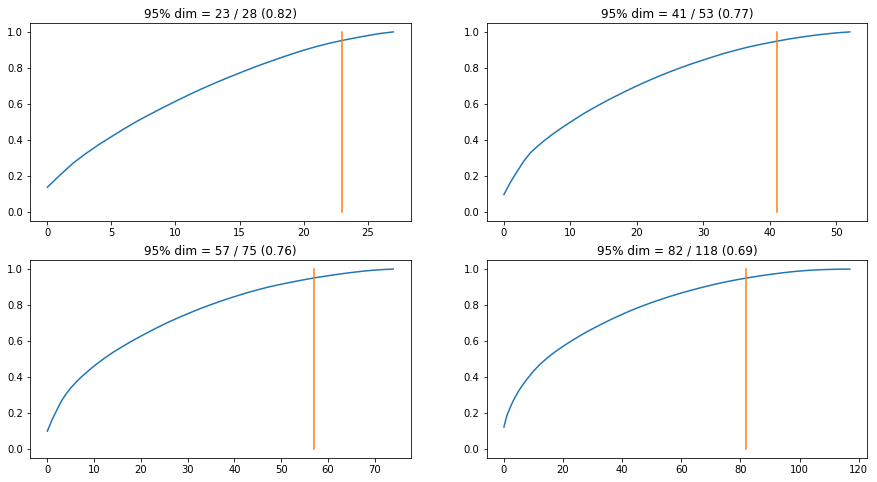

In [9]:
from sklearn.preprocessing import StandardScaler

cuts = [f80, f90, f95, f99]

fig = plt.figure(figsize=(15,8))
for i, fc in enumerate(cuts):
    xscale = StandardScaler().fit_transform(model_df[feat_imp.x.values[0:fc]]) 
    svs = np.linalg.svd(xscale, compute_uv=False)
    spectrum = np.cumsum(svs**2)
    spectrum_norm = spectrum / max(spectrum)

    ax = fig.add_subplot(2,2,i+1)
    plt.plot(spectrum_norm)
    c90 = np.argmin((spectrum_norm - 0.95)**2)
    plt.plot(c90*np.ones(2),[0,1])
    plt.title('95% dim = {} / {} ({})'.format(c90,fc, np.round(c90 / (1.0*fc),2)))

In general, we see reasonable independance of the features.

## Build Models on different Feature Subsets

In [168]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#Shuffle rows
model_df_shuf = model_df.sample(frac=1, random_state=1).reset_index(drop=True)

#Data is shuffled so we can just take bottom 10% for test set
test_pct = 0.1
test_index = int(model_df_shuf.shape[0]) * test_pct
test_df = model_df_shuf.loc[:test_index]
train_df = model_df_shuf.loc[test_index:]


In [89]:

def get_a_model(train_df, test_df, Y):
    rf_grid = {'n_estimators':[200], 'max_depth':[10], 'criterion':['mse']}
    lr_grid = {'normalize':[True,False]}
    gbdt_grid = {'n_estimators':[100,200,500],'max_depth':[5,7], 'loss':['ls','lad','huber'], 'alpha':[0.5],
                'learning_rate':[0.05,0.1]}


    kf = KFold(n_splits=8, random_state=10, shuffle=False)

    subsets = [feat_imp.x.values[0:f80], feat_imp.x.values[0:f90], feat_imp.x.values[0:f95], feat_imp.x.values[0:f99]]
    
    results = []
    for subset in subsets[0:2]:
        cf_rf = GridSearchCV(RandomForestRegressor(), rf_grid, cv=kf, scoring='neg_mean_squared_error')
        cf_lr = GridSearchCV(LinearRegression(), lr_grid, cv=kf, scoring='neg_mean_squared_error')
        cf_gbdt = GridSearchCV(GradientBoostingRegressor(), gbdt_grid, cv=kf, scoring='neg_mean_squared_error')
        
        cf_rf.fit(train_df[subset], train_df[Y])
        cf_lr.fit(train_df[subset], train_df[Y])
        cf_gbdt.fit(train_df[subset], train_df[Y])        
        
        if 'log' in Y:
            test_err_rf = ((np.exp(cf_rf.best_estimator_.predict(test_df[subset])) - test_df.avg_consumption)**2).mean()
            test_err_lr = (np.exp((cf_lr.best_estimator_.predict(test_df[subset])) - test_df.avg_consumption)**2).mean()
            test_err_gbdt = (np.exp((cf_gbdt.best_estimator_.predict(test_df[subset])) - test_df.avg_consumption)**2).mean()

        else:
            test_err_rf = ((cf_rf.best_estimator_.predict(test_df[subset]) - test_df[Y])**2).mean()
            test_err_lr = ((cf_lr.best_estimator_.predict(test_df[subset]) - test_df[Y])**2).mean()
            test_err_gbdt = ((cf_gbdt.best_estimator_.predict(test_df[subset]) - test_df[Y])**2).mean()
            
        results.append(('rf', len(subset), cf_rf.best_score_, str(cf_rf.best_params_),test_err_rf))
        results.append(('lr', len(subset), cf_lr.best_score_, str(cf_lr.best_params_),test_err_lr))
        results.append(('gb', len(subset), cf_gbdt.best_score_, str(cf_gbdt.best_params_),test_err_gbdt))

    return  pd.DataFrame(results, columns=['algo','subset','score','params','test_score'])

In [90]:
cv_results_df = get_a_model(train_df, test_df, 'avg_consumption')

In [93]:
cv_results_df.params.values

array(["{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}",
       "{'normalize': False}",
       "{'alpha': 0.5, 'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 5, 'n_estimators': 100}",
       "{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 200}",
       "{'normalize': True}",
       "{'alpha': 0.5, 'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 7, 'n_estimators': 100}"],
      dtype=object)

Let's do some residual analysis on the best model, before training on everything

In [208]:
import ast

rf = 1

if rf == 1:
    best_params = ast.literal_eval(cv_results_df.loc[0].params)
    best_model = RandomForestRegressor(**best_params)
else:
    best_params = ast.literal_eval(cv_results_df.loc[2].params)
    best_params['n_estimators'] = 200
    best_params['learning_rate'] = 0.05
    best_model = GradientBoostingRegressor(**best_params)
    print(best_params)
    
best_subset = feat_imp.x.values[0:f80]

best_model.fit(train_df[best_subset],train_df[Y])




RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [123]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def evaluate(predictions, labels):
    errors = abs(predictions - labels)
    
    print('MAE', mean_absolute_error(predictions, labels))
    print('MSE', mean_squared_error(predictions, labels))
    print('R2', r2_score(labels, predictions))
    #print('Model_scorer', model.score(features, labels))
    print('Average Error: ', np.mean(errors), 'kwh')
    

In [209]:


best_test_preds = best_model.predict(test_df[best_subset])
best_train_preds = best_model.predict(train_df[best_subset])

print('Train Error')
evaluate(best_train_preds, train_df[Y])

print('Test Error')
evaluate(best_test_preds, test_df[Y])

Train Error
MAE 0.04712180909508804
MSE 0.00621427365592895
R2 0.7526064938717457
Average Error:  0.04712180909508792 kwh
Test Error
MAE 0.06559819906354007
MSE 0.013929524291925904
R2 0.334128836399293
Average Error:  0.06559819906354009 kwh


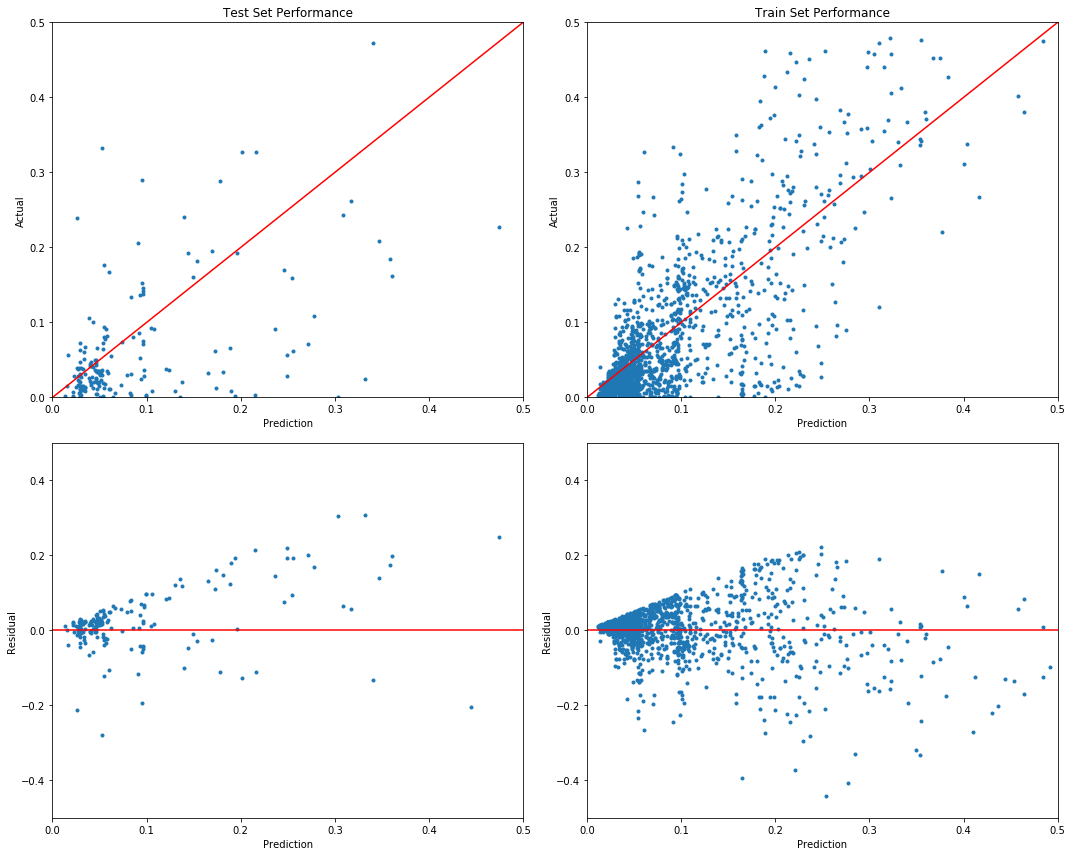

In [137]:
fig = plt.figure(figsize=(15,12))

mx = 0.5

ax = fig.add_subplot(2,2,1)
plt.title('Test Set Performance')

plt.plot(best_test_preds, test_df[Y],'.')
plt.ylim([0,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Prediction')
plt.ylabel('Actual')

ax = fig.add_subplot(2,2,2)
plt.title('Train Set Performance')

plt.plot(best_train_preds, train_df[Y],'.')
plt.ylim([0,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Prediction')
plt.ylabel('Actual')


ax = fig.add_subplot(2,2,3)

plt.plot(best_test_preds, best_test_preds-test_df[Y],'.')
plt.ylim([-mx,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,0],'r-')
plt.xlabel('Prediction')
plt.ylabel('Residual')

ax = fig.add_subplot(2,2,4)

plt.plot(best_train_preds, best_train_preds-train_df[Y],'.')
plt.ylim([-mx,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,0],'r-')
plt.xlabel('Prediction')
plt.ylabel('Residual')

fig.tight_layout()

## Model on the Log
The fit is decent but these are quite skewed. Let's run the same exploration on the log transform of the outcime

(array([ 30.,   0.,   0.,   2.,   7.,  25., 131., 672., 589., 217.]),
 array([-1.59902623e+01, -1.43912360e+01, -1.27922098e+01, -1.11931836e+01,
        -9.59415732e+00, -7.99513108e+00, -6.39610484e+00, -4.79707860e+00,
        -3.19805236e+00, -1.59902613e+00,  1.13636357e-07]),
 <a list of 10 Patch objects>)

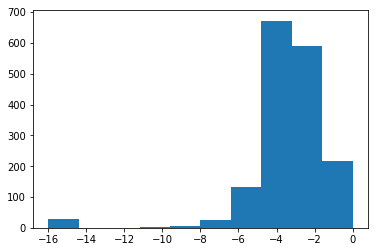

In [267]:
y_min = train_df[Y][(train_df[Y]>0)].min()
plt.hist(np.log(train_df[Y] + y_min))

In [275]:
y_min = train_df[Y][(train_df[Y]>0)].min()

train_df['log_Y'] = np.log(train_df[Y] + y_min)
test_df['log_Y'] = np.log(test_df[Y] + y_min)

log_cv_results_df = get_a_model(train_df, test_df, 'log_Y')

In [277]:
log_cv_results_df

,algo,subset,score,params,test_score
0,rf,28,-3.843226,"{'n_estimators': 200, 'max_depth': 5}",0.014840
1,lr,28,-29.970106,{'normalize': False},0.003405
2,rf,54,-3.817400,"{'n_estimators': 50, 'max_depth': 5}",0.015854
3,lr,54,-11.046789,{'normalize': False},0.004067
4,rf,77,-3.830694,"{'n_estimators': 50, 'max_depth': 5}",0.015484
5,lr,77,-5.819456,{'normalize': True},0.004615
6,rf,119,-3.844315,"{'n_estimators': 50, 'max_depth': 5}",0.014753
7,lr,119,-6.647768,{'normalize': False},0.004216


In [281]:
best_params_log = ast.literal_eval(log_cv_results_df.loc[0].params)
best_subset_log = feat_imp.x.values[0:f80]

best_model_log = RandomForestRegressor(**best_params_log)
best_model_log.fit(train_df[best_subset_log],train_df[['log_Y']])

best_test_preds_log = np.exp(best_model_log.predict(test_df[best_subset]))
best_train_preds_log = np.exp(best_model_log.predict(train_df[best_subset]))

print('Train Error')
evaluate(best_train_preds_log, train_df.avg_consumption)

print('Test Error')
evaluate(best_test_preds_log, test_df.avg_consumption)

Train Error
('MAE', 0.06548439957603834)
('MSE', 0.01870874481382994)
('R2', 0.25519501859460736)
('Average Error: ', 0.0654843995760383, 'kwh')
Test Error
('MAE', 0.05575043462012782)
('MSE', 0.014852263697769274)
('R2', 0.29001924952522484)
('Average Error: ', 0.055750434620127805, 'kwh')


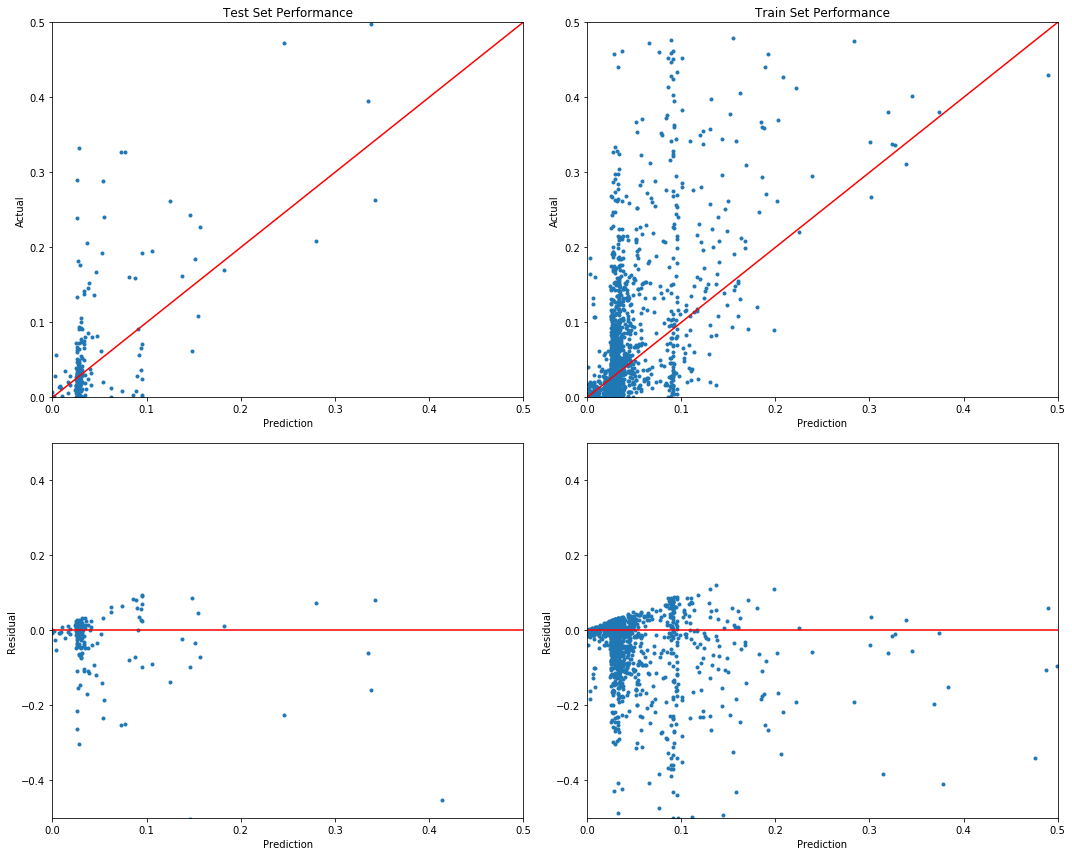

In [282]:
fig = plt.figure(figsize=(15,12))

mx = 0.5

ax = fig.add_subplot(2,2,1)
plt.title('Test Set Performance')

plt.plot(best_test_preds_log, test_df[Y],'.')
plt.ylim([0,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Prediction')
plt.ylabel('Actual')

ax = fig.add_subplot(2,2,2)
plt.title('Train Set Performance')

plt.plot(best_train_preds_log, train_df[Y],'.')
plt.ylim([0,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,1],'r-')
plt.xlabel('Prediction')
plt.ylabel('Actual')


ax = fig.add_subplot(2,2,3)

plt.plot(best_test_preds_log, best_test_preds_log-test_df[Y],'.')
plt.ylim([-mx,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,0],'r-')
plt.xlabel('Prediction')
plt.ylabel('Residual')

ax = fig.add_subplot(2,2,4)

plt.plot(best_train_preds_log, best_train_preds_log-train_df[Y],'.')
plt.ylim([-mx,mx]);plt.xlim([0,mx])
plt.plot([0,1],[0,0],'r-')
plt.xlabel('Prediction')
plt.ylabel('Residual')

fig.tight_layout()

In [ ]:
test_roll = test_df[['country','developer_code','avg_consumption']]
test_roll['pred'] = best_test_preds

tg = test_roll.groupby(['country','developer_code']).agg([np.median, len]).reset_index()
tg.columns = ['country','developer_code','act_mean', 'act_n','pred_mean','pred_n']
tg = tg.sort_values(by='act_n', ascending=False)
tg = tg.drop('pred_n', axis=1)
tg['village_test_error'] = tg['pred_mean'] / tg['act_mean'] - 1
tg

## Try Quantile Regression

In [12]:
from skgarden import RandomForestQuantileRegressor


In [210]:
rf_args = {'max_depth':10, 'n_estimators':200}

rfqr = RandomForestQuantileRegressor(**rf_args, criterion='mae')


subset = feat_imp.x.values[0:f80]
rfqr.fit(train_df[subset], train_df[Y])

rf_mse = RandomForestRegressor(max_depth=10, n_estimators=200, criterion='mse')
rf_mse.fit(train_df[subset], train_df[Y])

rf_mae = RandomForestRegressor(max_depth=10, n_estimators=200, criterion='mae')
rf_mae.fit(train_df[subset], train_df[Y])


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [211]:
q_up = rfqr.predict(train_df[subset], quantile=97.5)
q_med = rfqr.predict(test_df[subset], quantile=50)
q_lo = rfqr.predict(test_df[subset], quantile=2.5)
q_75 = rfqr.predict(test_df[subset], quantile=75)

mse_pred = rf_mse.predict(test_df[subset])
mae_pred = rf_mae.predict(test_df[subset])

In [212]:
print('Quantile Median')
evaluate(q_med, test_df[Y])
print('')
print('RF-MSE')
evaluate(mse_pred, test_df[Y])
print('')         
print('RF-MAE')  
evaluate(mae_pred, test_df[Y])

Quantile Median
MAE 0.049903150244603164
MSE 0.011262989773871931
R2 0.46159682490391396
Average Error:  0.04990315024460316 kwh

RF-MSE
MAE 0.0647950178104649
MSE 0.013502656111814434
R2 0.3545343582131065
Average Error:  0.0647950178104649 kwh

RF-MAE
MAE 0.05434444872751827
MSE 0.011104655518273653
R2 0.46916565588504
Average Error:  0.05434444872751831 kwh


## Get a Partial Dependence Plot

In [327]:
import warnings
warnings.filterwarnings('ignore')

tar_range = [model_df['tariff'].min(), np.percentile(model_df['tariff'].values, 95)]
tar_set = np.linspace(tar_range[0], tar_range[1], 50)


test_pdp = []
train_pdp = []
lo_pdp = []
hi_pdp = []

var = 'age'
hh_med = train_df[[var]].median().values[0]

for tar in tar_set:
    new_pd_test = test_df.copy()
    new_pd_train = train_df.copy()
    
    new_pd_test['tariff'] = tar
    new_pd_train['tariff'] = tar
    
    test_pdp.append(rf_mae.predict(new_pd_test[subset]).mean())
    train_pdp.append(rf_mae.predict(new_pd_train[subset]).mean())
    fh = (train_df[var]>= hh_med)
    fl = (train_df[var]<hh_med)
    lo_pdp.append(rf_mae.predict(new_pd_train[subset][fl]).mean())
    hi_pdp.append(rf_mae.predict(new_pd_train[subset][fh]).mean())

In [328]:
#Fit a linear regression on the training data to get a sense of price elasticity
new_df = pd.DataFrame({'tariff':tar_set,
                       'X2':tar_set**2,
                       'X3':tar_set**3,
                       'X4':tar_set**4
                       })

trn_df = train_df.copy()
trn_df['X2'] = trn_df['tariff']**2 
trn_df['X3'] = trn_df['tariff']**3 
trn_df['X4'] = trn_df['tariff']**4

tar_lr = LinearRegression()
tar_lr.fit(trn_df[['tariff','X2','X3','X4']], trn_df[Y])

tar_lr_pred = tar_lr.predict(new_df[['tariff','X2','X3','X4']])


(0, 0.4)

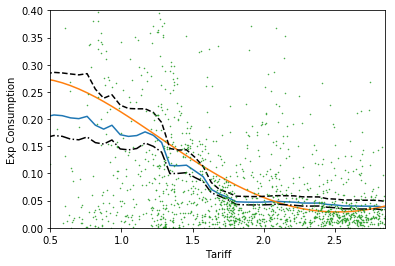

In [329]:
plt.plot(tar_set,train_pdp)
plt.plot(tar_set,tar_lr_pred)
plt.plot(tar_set,lo_pdp,'k--')
plt.plot(tar_set,hi_pdp,'k-.')
plt.plot(train_df['tariff'],train_df[Y],'.', markersize=1)

plt.xlabel('Tariff')
plt.ylabel('Exp Consumption')
plt.xlim([0.5,tar_set.max()])
plt.ylim([0,0.4])




## Look for an interaction term with Price

In order to develop price sensitivity segments, look for important variables that have interaction effects

In [271]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

Y = 'avg_consumption'

intvars = list(set(subset) - set(['tariff']))


res_list = []


for v in intvars:
    base_df = model_df.copy()
    base_df['X2'] = base_df['tariff']**2 
    base_df['X3'] = base_df['tariff']**3 
    base_df['X4'] = base_df['tariff']**4
    base_df['int'] = base_df.tariff * base_df[v]
    base_df = sm.add_constant(base_df[['tariff','X2','X3','X4',v,'int',Y]])
    
    model = sm.OLS(base_df[Y], base_df[['const','tariff',v, 'int']])
    r = model.fit()
    res_list.append((v,r._results.params[2], r._results.tvalues[2],r._results.params[3],r._results.tvalues[3]))
    

res_df = pd.DataFrame(res_list, columns = ['var','var_coef','var_t','int_coef','int_t'])

In [344]:
sig_res_df = res_df[(np.abs(res_df.var_t)>2) & (np.abs(res_df.int_t)>2)].copy()
sig_res_df['tot'] = np.abs(sig_res_df.var_t) + np.abs(sig_res_df.int_t)
sig_res_df = sig_res_df.sort_values(by='tot',ascending=False)
sig_res_df

,var,var_coef,var_t,int_coef,int_t,tot
6,non_self_generated_electricity_monthly_consump...,0.019084,12.380451,-0.010073,-12.378719,24.759170
19,uses_of_non_self_generated_electricity_has_fan,0.295520,11.666594,-0.110343,-8.604578,20.271172
13,years_in_community,-0.004990,-7.595532,0.002038,6.240844,13.836376
14,non_self_generated_electricity_monthly_expenses,0.000005,7.650765,-0.000001,-4.228385,11.879150
10,food,0.001790,7.245750,-0.000585,-4.401751,11.647501
1,phone_charger_type_of_use,0.392022,6.464609,-0.151111,-4.890374,11.354983
24,achieved_important_things_i_want,0.071014,5.674671,-0.030160,-5.057476,10.732147
25,energy,0.005955,7.365212,-0.001343,-3.143303,10.508515
3,credit_recharge_average,0.000045,5.455205,-0.000018,-4.924163,10.379369
9,light_bulbs,0.034203,6.098575,-0.013648,-4.277854,10.376429


Now plot PDP's for each of the significant interaction variables

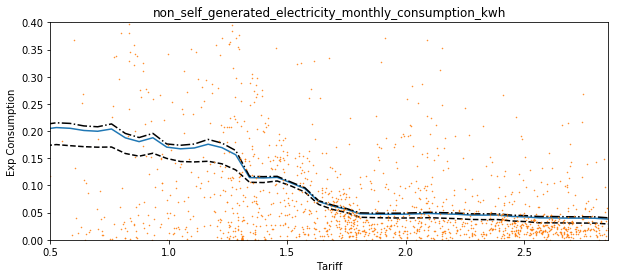

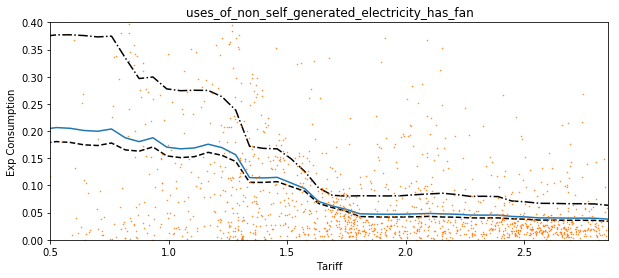

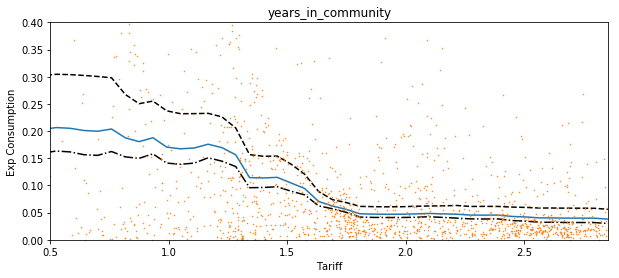

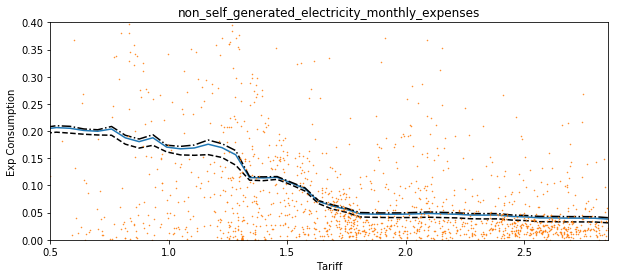

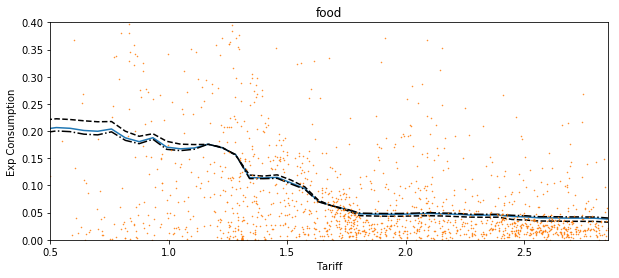

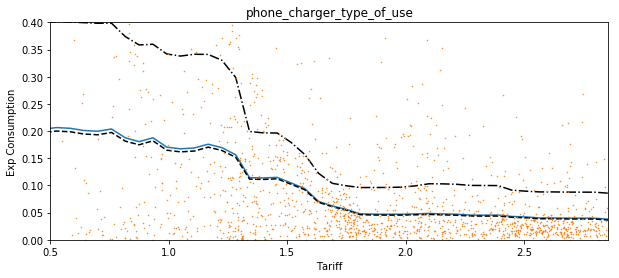

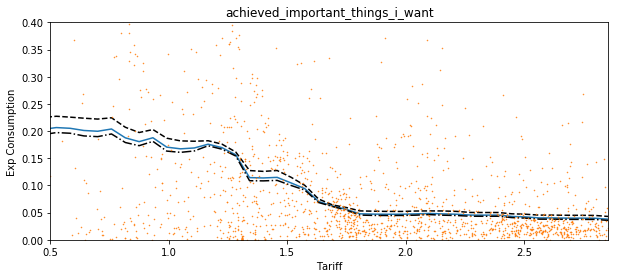

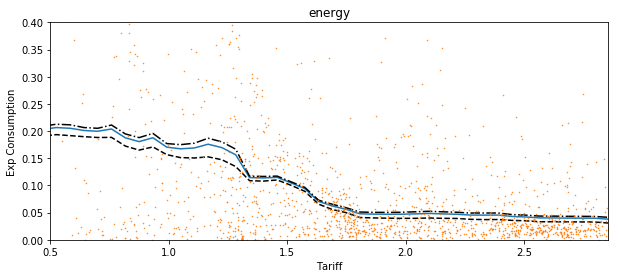

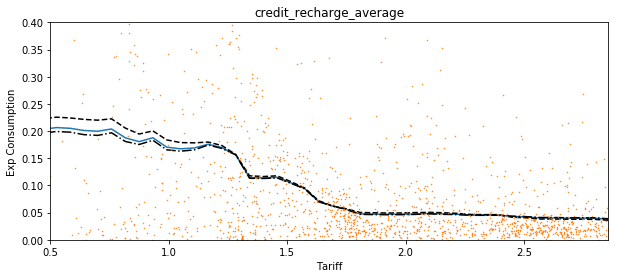

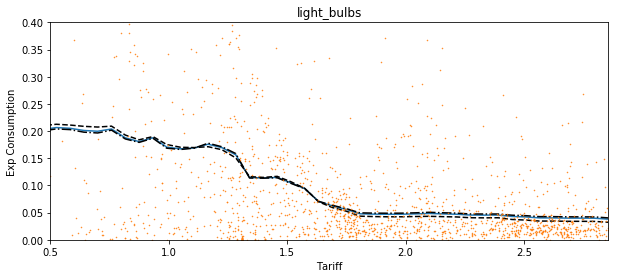

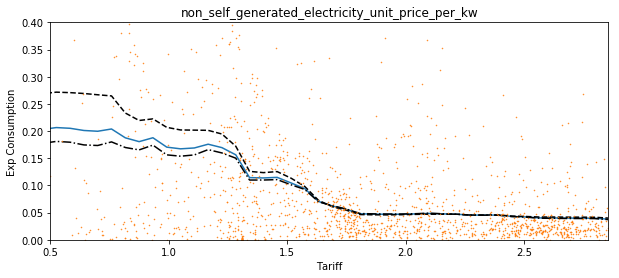

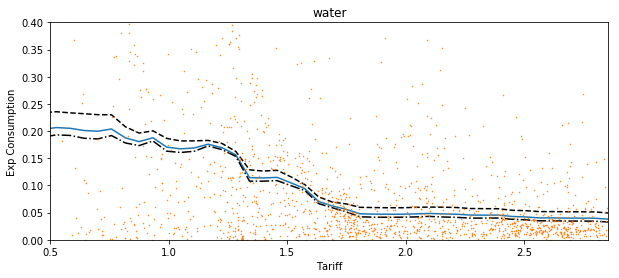

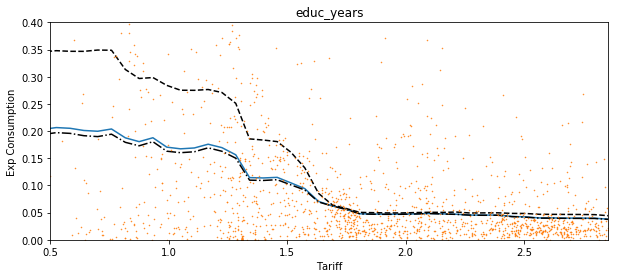

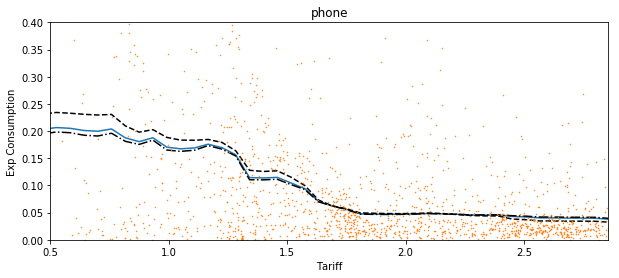

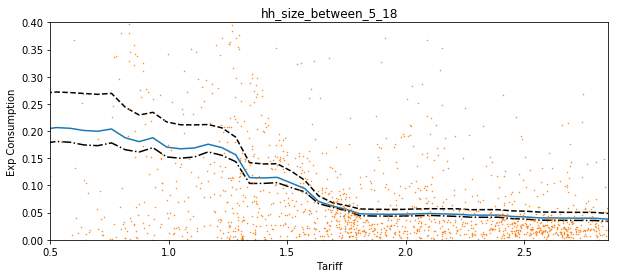

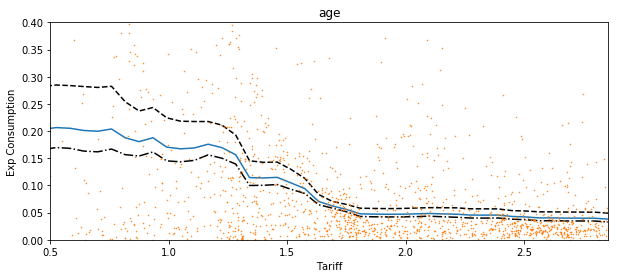

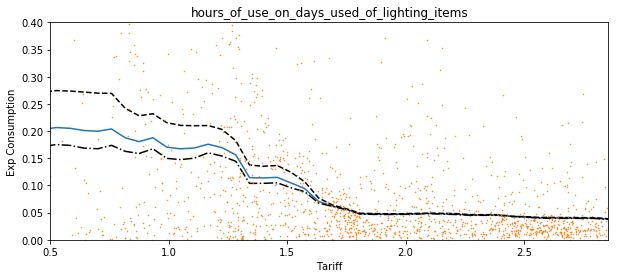

In [381]:
tar_range = [model_df['tariff'].min(), np.percentile(model_df['tariff'].values, 95)]
tar_set = np.linspace(tar_range[0], tar_range[1], 50)


test_pdp = []
train_pdp = []
lo_pdp = []
hi_pdp = []



for var in sig_res_df['var'].values:
    hh_med = train_df[[var]].median().values[0]
    train_pdp = []
    lo_pdp = []
    hi_pdp = []
    
    for tar in tar_set:
        new_pd_train = model_df.copy()
        new_pd_train['tariff'] = tar
        train_pdp.append(rf_mae.predict(new_pd_train[subset]).mean())
        
        if new_pd_train[var].value_counts().shape[0]==2:
            hh_med = 1
            
        fh = (new_pd_train[var]>= hh_med)
        fl = (new_pd_train[var]<hh_med)
        lo_pdp.append(rf_mae.predict(new_pd_train[subset][fl]).mean())
        hi_pdp.append(rf_mae.predict(new_pd_train[subset][fh]).mean())
    
    
    plt.figure(figsize=(10,4))
    plt.plot(tar_set,train_pdp)
    plt.plot(tar_set,lo_pdp,'k--')
    plt.plot(tar_set,hi_pdp,'k-.')
    plt.plot(train_df['tariff'],train_df[Y],'.', markersize=1)

    plt.xlabel('Tariff')
    plt.ylabel('Exp Consumption')
    plt.xlim([0.5,tar_set.max()])
    plt.ylim([0,0.4])
    plt.title(var)



## Village Error Analysis
- Check errors on test set by village and developer code
- Run a multivariate regression and do the same

In [394]:
err_df = test_df[[Y,'village_code','developer_code']].copy()
err_df['pred'] = mae_pred
err_df['err_sq'] = (err_df[Y] - err_df.pred)**2
err_df['err_abs'] = np.abs(err_df[Y] - err_df.pred)

In [406]:
err_grp = err_df.drop('developer_code',axis=1).groupby('village_code').mean().reset_index(drop=True)
err_cnt = pd.DataFrame(err_df.village_code.value_counts()).rename({'village_code':'cnt'}, axis=1)
err_grp = err_grp.merge(err_cnt,left_index=True,right_index=True)
err_grp

,avg_consumption,pred,err_sq,err_abs,cnt
0,0.032697,0.101443,0.004726,0.068745,1
1,0.100305,0.145463,0.004238,0.051537,6
2,0.076295,0.074924,0.001924,0.032204,11
3,0.073190,0.104727,0.007701,0.060384,20
4,0.059614,0.059345,0.005546,0.042221,43
5,0.075005,0.055771,0.005077,0.038595,34
6,0.029974,0.031793,0.001817,0.025599,17
7,0.041603,0.081284,0.003176,0.050167,11
8,0.069668,0.092853,0.004044,0.050381,20
9,0.449134,0.326434,0.116591,0.240536,11


In [417]:
err_grp = err_df.drop('village_code',axis=1).groupby('developer_code').mean().reset_index()
err_cnt = pd.DataFrame(err_df.developer_code.value_counts()).rename({'developer_code':'cnt'}, axis=1)
err_grp = err_grp.merge(err_cnt,left_on='developer_code',right_index=True)
err_grp

,developer_code,avg_consumption,pred,err_sq,err_abs,cnt
0,1,0.046714,0.053530,0.004622,0.040496,88
1,2,0.121059,0.115480,0.017096,0.067264,97
2,5,0.000000,0.019813,0.000393,0.019813,1


In [435]:
#Get errors on insample results

lr = LinearRegression()
lr.fit(model_df[subset], model_df[Y])

err_df = model_df[[Y,'village_code','developer_code','tariff']].copy()
err_df['pred'] = lr.predict(model_df[subset])
err_df['err_sq'] = (err_df[Y] - err_df.pred)**2
err_df['err_abs'] = np.abs(err_df[Y] - err_df.pred)


In [436]:
err_grp = err_df.drop('developer_code',axis=1).groupby('village_code').mean().reset_index(drop=True)
err_cnt = pd.DataFrame(err_df.village_code.value_counts()).rename({'village_code':'cnt'}, axis=1)
err_grp = err_grp.merge(err_cnt,left_index=True,right_index=True)
err_grp

,avg_consumption,tariff,pred,err_sq,err_abs,cnt
0,0.077106,0.724108,0.162412,0.019486,0.123401,15
1,0.178451,1.238369,0.154714,0.032367,0.114470,82
2,0.094310,1.708534,0.093427,0.021237,0.078191,119
3,0.059309,2.044814,0.088596,0.010145,0.072130,227
4,0.096217,2.118251,0.094896,0.014694,0.078961,381
5,0.061175,2.304952,0.061984,0.006725,0.046539,298
6,0.064668,2.299071,0.051318,0.005910,0.054186,206
7,0.068462,1.413489,0.114019,0.017325,0.098250,92
8,0.107014,1.711998,0.106222,0.020337,0.095619,220
9,0.359719,0.986080,0.214829,0.090341,0.204927,92


In [437]:
err_grp.avg_consumption / model_df[Y].mean()



village_code in [1,3,4,5,6,9]

0     0.793205
1     1.835752
2     0.970180
3     0.610124
4     0.989799
5     0.629315
6     0.665252
7     0.704280
8     1.100876
9     3.700495
10    0.736200
Name: avg_consumption, dtype: float64

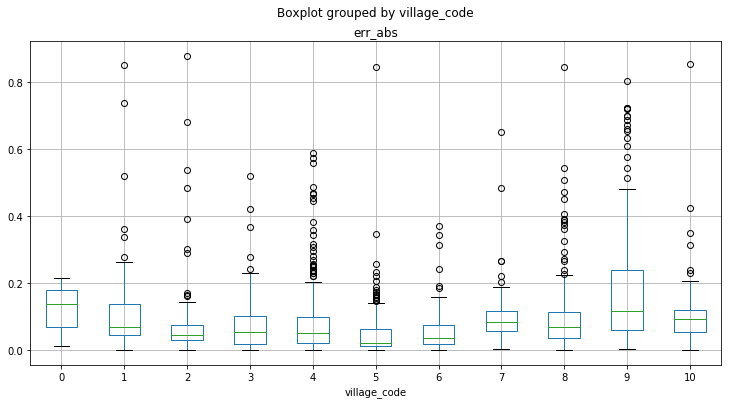

In [433]:
err_df.boxplot('err_abs',by='village_code', figsize=(12,6))

In [421]:
err_grp = err_df.drop('village_code',axis=1).groupby('developer_code').mean().reset_index()
err_cnt = pd.DataFrame(err_df.developer_code.value_counts()).rename({'developer_code':'cnt'}, axis=1)
err_grp = err_grp.merge(err_cnt,left_on='developer_code',right_index=True)
err_grp

,developer_code,avg_consumption,pred,err_sq,err_abs,cnt
0,1,0.060073,0.060721,0.008697,0.057717,826
1,2,0.125090,0.126603,0.025188,0.102106,1005
2,5,0.191954,0.118538,0.032253,0.132752,28


## Model with Village & Developer Code

In [445]:
def add_codes(df):
    newvars = []
    for village_code in [1,3,4,5,6,7,9,10]:
        nv = 'vc_{}'.format(village_code)
        df[nv] = 1*(df.village_code==village_code)
        newvars.append(nv)
        
    df['dc_2'] = 1*(df.developer_code==2)
    newvars.append('dc_2')
    return df, newvars

train_df2, newvars = add_codes(train_df.copy())
test_df2, newvars = add_codes(test_df.copy())

In [446]:
newset = list(subset) + newvars
rf_mae2 = RandomForestRegressor(max_depth=10, n_estimators=200, criterion='mae')
rf_mae2.fit(train_df2[newset], train_df2[Y])


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [447]:
mae_pred2 = rf_mae2.predict(test_df2[newset])

In [448]:
print('RF-MAE-No V&D C')
evaluate(mae_pred, test_df[Y])
print('')         
print('RF-MAE-Has V&D C')  
evaluate(mae_pred2, test_df2[Y])

RF-MAE-No V&D C
MAE 0.05434444872751827
MSE 0.011104655518273653
R2 0.46916565588504
Average Error:  0.05434444872751831 kwh

RF-MAE-Has V&D C
MAE 0.04894488543432169
MSE 0.007647262482047781
R2 0.6344389470476919
Average Error:  0.04894488543432168 kwh


## Individual Conditional Expectation

In [449]:
tar_qs = np.percentile(model_df.tariff, [10,25,50,75,90])

preds = []
for i, tar in enumerate(tar_qs):
    pd_test = pd.concat([test_df2.copy(),train_df2.copy()])    
    pd_test['tariff'] = tar
    
    preds.append(rf_mae2.predict(pd_test[newset]))
    
    
for i in range(len(preds)):
    pd_test['pred_{}'.format(i)] = preds[i]

In [476]:
from sklearn.cluster import KMeans

cvars = ['pred_{}'.format(i) for i in range(len(preds))]

kmeans = KMeans(n_clusters=6, random_state=0).fit(pd_test[cvars])

In [477]:
kmeans.__dict__

{'n_clusters': 6,
 'init': 'k-means++',
 'max_iter': 300,
 'tol': 0.0001,
 'precompute_distances': 'auto',
 'n_init': 10,
 'verbose': 0,
 'random_state': 0,
 'copy_x': True,
 'n_jobs': 1,
 'algorithm': 'auto',
 'cluster_centers_': array([[0.09433144, 0.06554006, 0.03706304, 0.02852532, 0.02453003],
        [0.30918952, 0.17875205, 0.04207226, 0.03950262, 0.03793283],
        [0.26414095, 0.19358688, 0.21201913, 0.19619779, 0.18411768],
        [0.1870188 , 0.11437228, 0.04466804, 0.03799127, 0.03442163],
        [0.38469087, 0.29557688, 0.44923299, 0.54799271, 0.53122643],
        [0.45519288, 0.29073329, 0.09416926, 0.1003819 , 0.10017305]]),
 'labels_': array([0, 0, 3, ..., 3, 1, 3], dtype=int32),
 'inertia_': 8.06537300170487,
 'n_iter_': 6}

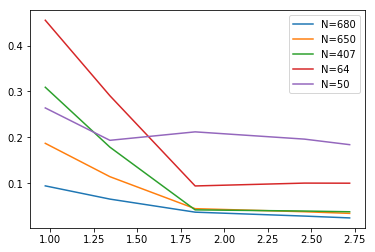

In [478]:
ccnt = pd.Series(kmeans.predict(pd_test[cvars])).value_counts()
for i in ccnt.index.values:
    if ccnt.loc[i]>20:
        plt.plot(tar_qs, kmeans.cluster_centers_[i], label='N={}'.format(ccnt.loc[i]))
plt.legend()

## Isolation Forests - look for outliers

In [479]:
from sklearn.ensemble import IsolationForest

In [496]:
clf = IsolationForest(max_samples=100, random_state=10)
clf.fit(model_df[list(subset) + [Y]])
iso_preds = clf.predict(model_df[list(subset) + [Y]])
model_df['outlier'] = iso_preds
model_df3 = model_df[(model_df.outlier==1)]


/Users/briandalessandro/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [497]:
model_df_shuf3 = model_df3.sample(frac=1, random_state=1).reset_index(drop=True)

#Data is shuffled so we can just take bottom 10% for test set
test_pct = 0.1
test_index = int(model_df_shuf3.shape[0]) * test_pct
test_df3 = model_df_shuf3.loc[:test_index]
train_df3 = model_df_shuf3.loc[test_index:]


In [499]:
rf_mae3 = RandomForestRegressor(max_depth=10, n_estimators=200, criterion='mae')
rf_mae3.fit(train_df3[subset], train_df3[Y])


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [501]:
mae_pred3 = rf_mae3.predict(test_df3[subset])

evaluate(mae_pred3, test_df3[Y])

MAE 0.05509379018851107
MSE 0.013453537056579664
R2 0.21484514508426167
Average Error:  0.055093790188511085 kwh


In [502]:
model_df[list(subset) + [Y,'outlier']].groupby('outlier').mean().reset_index()

,outlier,tariff,non_self_generated_electricity_monthly_consumption_kwh,energy,years_in_community,uses_of_non_self_generated_electricity_has_fan,non_self_generated_electricity_monthly_expenses,achieved_important_things_i_want,hh_expenses,phone_charger_type_of_use,...,rent,hh_income,fetching_time_minutes,credit_recharge_average,food,phone_charger_hours_of_use_on_days_used,transportation,rank_appliances_to_buy__3rd_choice,water,avg_consumption
0,-1,1.650115,171.365591,21.77421,25.752688,0.365591,29092.817204,2.763441,313.456586,0.150538,...,6.029892,408.141935,24.204301,2300.236559,83.442796,20.559140,40.071419,17.139785,11.472301,0.240094
1,1,1.925535,3.042439,6.10806,30.220562,0.105200,10927.799163,2.693963,77.021065,0.018530,...,0.447552,95.664368,32.406455,1433.026898,31.160220,7.811118,5.365107,13.953975,3.635140,0.081323


## To-Do

- Think about clusters both in terms of price sensitivity and expected usage at given price
- Do error analysis by developer & village (done)
-- perhaps build a simple regression model (done)
- Look at Villages for OSM coverage
- Models with village code (done)
- do the price elasticity by village
- do a village profile 

Questions for wrap up
- How do they recommend wrapping this up:
- 

## Scratch